In [127]:
! pip install xgboost

In [128]:
#IMPORTATION DU FICHIER
import time
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.pipeline import Pipeline # Import Pipeline
from sklearn.compose import ColumnTransformer # Import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler # Import transformers
from sklearn.impute import SimpleImputer # Import imputer
import joblib 

In [129]:
# 1. Charger les données
df_pret = pd.read_csv(r"C:\Users\HP 840 G5\Downloads\loan_data.csv")
df_pret.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [130]:
#information sur le fichier
df_pret.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [131]:
df_pret.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


In [132]:
#Gérer les valeurs manquantes
df_pret.isnull().sum()

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

In [133]:
#determinons les valeurs doubles
df_pret.duplicated().sum()

np.int64(0)

In [134]:
# verifions s'il existe des valeurs aberrantes
col_numeriques = list(df_pret.select_dtypes(include=["int64","float64"]).columns)
# Initialiser une liste pour stocker les colonnes avec valeurs aberrantes
colonnes_aberrantes = []

def valeurs_aberrantes(df_pret, col_numeriques):
    # Définir le seuil pour identifier les valeurs aberrantes en fonction du score Z
    seuil_z = 3
    # Boucle à travers chaque colonne numérique
    for colonne in col_numeriques:
        # Calculer la moyenne et l'écart-type de la colonne actuelle
        moyenne = df_pret[colonne].mean()
        ecart_type = df_pret[colonne].std()

        # Calculer les scores Z pour la colonne actuelle
        scores_z = (df_pret[colonne] - moyenne) / ecart_type

        # Identifier les valeurs aberrantes pour la colonne actuelle
        valeurs_aberrantes = df_pret[abs(scores_z) > seuil_z]

             # Afficher les valeurs aberrantes pour la colonne actuelle
        if not valeurs_aberrantes.empty:
             colonnes_aberrantes.append(colonne)
             print(f"Voici les valeurs aberrantes dans la colonne '{colonne}' avec zscore = 3 :")
             for index, valeur in valeurs_aberrantes[colonne].items():
                print(f"Ligne: {index}, Valeur: {valeur}")
    print(f"\nIl y a {len(colonnes_aberrantes)} colonnes avec des valeurs aberrantes : {colonnes_aberrantes}")

valeurs_aberrantes(df_pret,col_numeriques)

Voici les valeurs aberrantes dans la colonne 'person_age' avec zscore = 3 :
Ligne: 81, Valeur: 144.0
Ligne: 183, Valeur: 144.0
Ligne: 575, Valeur: 123.0
Ligne: 747, Valeur: 123.0
Ligne: 29121, Valeur: 50.0
Ligne: 29139, Valeur: 46.0
Ligne: 29143, Valeur: 47.0
Ligne: 29144, Valeur: 46.0
Ligne: 29147, Valeur: 47.0
Ligne: 29163, Valeur: 48.0
Ligne: 29182, Valeur: 50.0
Ligne: 29193, Valeur: 47.0
Ligne: 29197, Valeur: 46.0
Ligne: 29204, Valeur: 46.0
Ligne: 29211, Valeur: 49.0
Ligne: 29220, Valeur: 47.0
Ligne: 29229, Valeur: 46.0
Ligne: 29239, Valeur: 47.0
Ligne: 29243, Valeur: 48.0
Ligne: 29252, Valeur: 50.0
Ligne: 29269, Valeur: 47.0
Ligne: 29270, Valeur: 48.0
Ligne: 29278, Valeur: 47.0
Ligne: 29282, Valeur: 46.0
Ligne: 29285, Valeur: 48.0
Ligne: 29300, Valeur: 48.0
Ligne: 29305, Valeur: 50.0
Ligne: 29325, Valeur: 50.0
Ligne: 29350, Valeur: 47.0
Ligne: 29375, Valeur: 48.0
Ligne: 29376, Valeur: 47.0
Ligne: 29384, Valeur: 50.0
Ligne: 29386, Valeur: 49.0
Ligne: 29387, Valeur: 46.0
Ligne: 2939

In [135]:
# ENCODAGE DES VARIABLES CATÉGORIELLES

# Identify categorical columns
cat_cols = list(df_pret.select_dtypes(include=['object', 'category']).columns)

from sklearn.preprocessing import LabelEncoder # Import LabelEncoder

encoder = LabelEncoder()
for col in cat_cols:
    df_pret[col] = encoder.fit_transform(df_pret[col])

In [136]:
#standardisation des valeurs aberrantes
from sklearn.preprocessing import RobustScaler # Import RobustScaler

scaler = RobustScaler()
# Fit and transform only on the desired columns
scaled_data = scaler.fit_transform(df_pret[ ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']])

# Create a new DataFrame with the scaled data and original columns
df_pret[ ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']] = scaled_data
df_pret

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,-0.666667,0,4,0.100854,-0.571429,3,3.730699,4,1.138636,3.083333,-0.2,-1.144928,0,1
1,-0.833333,0,3,-1.127215,-0.571429,2,-0.967218,1,0.029545,-0.333333,-0.4,-1.971014,1,0
2,-0.166667,0,3,-1.124004,-0.142857,0,-0.345435,3,0.422727,2.666667,-0.2,-0.072464,0,1
3,-0.500000,0,1,0.261499,-0.571429,3,3.730699,3,0.959091,2.666667,-0.4,0.507246,0,1
4,-0.333333,1,4,-0.018792,-0.428571,3,3.730699,3,0.740909,3.416667,0.0,-0.782609,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,0.166667,1,0,-0.392650,0.285714,3,0.967218,3,1.056818,1.583333,-0.2,0.072464,0,1
44996,1.833333,0,0,-0.025687,1.857143,3,0.138174,2,0.695455,0.166667,1.4,-0.275362,0,1
44997,1.166667,1,0,-0.208006,0.428571,3,-0.722512,0,-0.225000,-0.583333,1.2,0.405797,0,1
44998,0.500000,1,1,-0.697413,0.000000,3,0.552696,1,0.504545,2.000000,0.4,-0.521739,0,1


In [137]:
# Paramètres d'affichage
import seaborn as sns # Import seaborn
import matplotlib.pyplot as plt # Import matplotlib.pyplot as well, as it's often used with seaborn

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

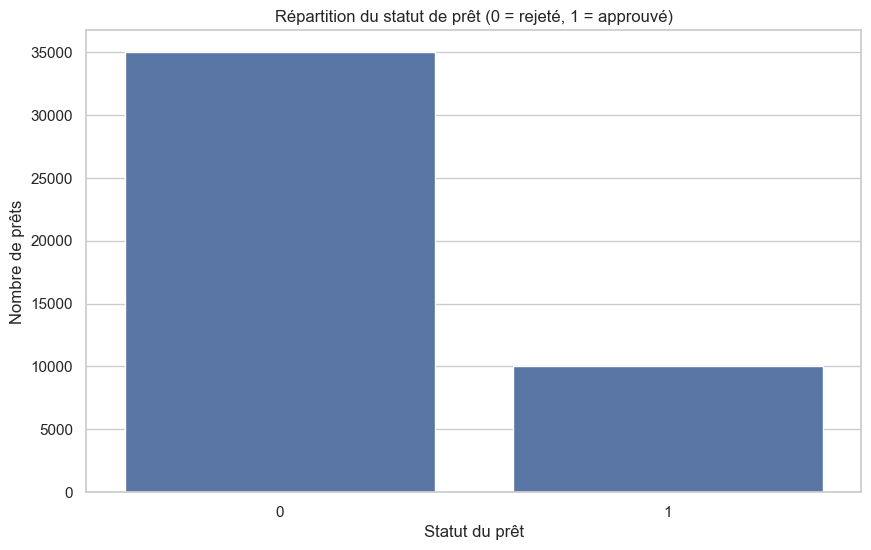

In [138]:
#Répartition du statut de prêt
sns.countplot(x="loan_status", data=df_pret)
plt.title("Répartition du statut de prêt (0 = rejeté, 1 = approuvé)")
plt.xlabel("Statut du prêt")
plt.ylabel("Nombre de prêts")
plt.show()

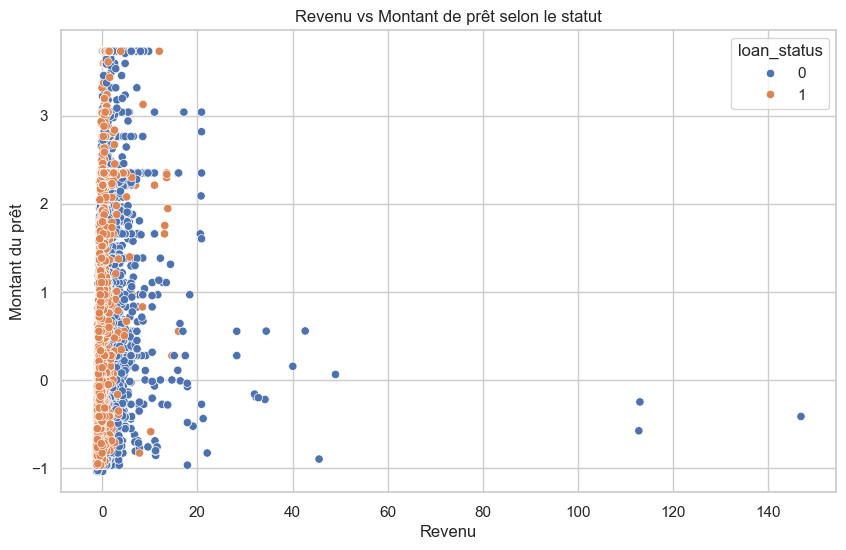

In [139]:
# Revenu vs Montant du prêt (selon statut)
sns.scatterplot(x="person_income", y="loan_amnt", hue="loan_status", data=df_pret) # Changed df to df_pret
plt.title("Revenu vs Montant de prêt selon le statut")
plt.xlabel("Revenu")
plt.ylabel("Montant du prêt")
plt.show()

In [140]:
#definis x et y 
X = df_pret.drop(columns=["loan_status"])
y = df_pret["loan_status"]

In [141]:

# Vérification des colonnes
print("Colonnes disponibles dans X :", X.columns.tolist())

# Adapter les noms des colonnes ici en fonction de l'affichage précédent
numeric_features = ['person_age', 'person_income', 'loan_amnt']  # <-- adapte ici si besoin
categorical_features = ['person_gender', 'person_education', 'loan_intent']

# Prétraitement
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Modèle
models = {
    "XGBoost": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
    ])
}

# Entraînement et évaluation
results = []

for name, model in models.items():
    print(f"\n📦 Entraînement du modèle : {name}")

    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model.named_steps['classifier'], "predict_proba") else y_pred

    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba),
        "Training Time (s)": training_time
    }

    results.append(metrics)

results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False).reset_index(drop=True)
print("\n📊 Résultats comparatifs :")
print(results_df)


Colonnes disponibles dans X : ['person_age', 'person_gender', 'person_education', 'person_income', 'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'previous_loan_defaults_on_file']

📦 Entraînement du modèle : XGBoost


c:\Users\HP 840 G5\Desktop\PROJET FINAL\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:03:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Résultats comparatifs :
     Model  Accuracy  Precision  Recall  F1 Score   ROC AUC  Training Time (s)
0  XGBoost     0.854   0.749273  0.5155  0.610782  0.866813           0.593895


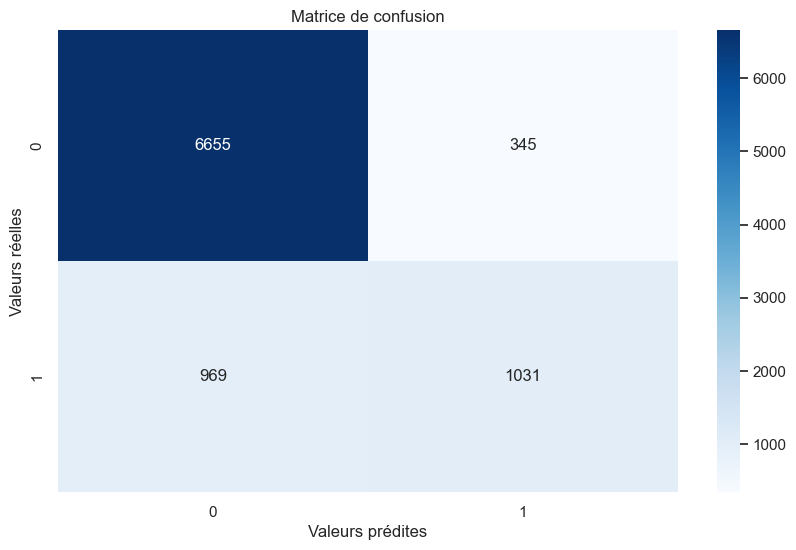

In [142]:
# Visualiser la matrice de confusion
from sklearn.metrics import confusion_matrix # Import the function

# Calculate the confusion matrix for the last model evaluated (XGBoost)
conf_matrix_lr = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion')
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.show()

In [143]:
# 9. Sauvegarde
# Get the trained pipeline from the models dictionary
trained_pipeline = models["XGBoost"]
# Ensure joblib is imported in this cell as well, in case of execution order issues
import joblib
joblib.dump(trained_pipeline, "xgboost_loan_model.joblib")
print("✅ Modèle entraîné et sauvegardé dans 'xgboost_loan_model.joblib'")

✅ Modèle entraîné et sauvegardé dans 'xgboost_loan_model.joblib'
